In [1]:
import oracledb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare

# Reserach Question 2
We will calculate the average wait time per body system (joint, skeletal, reproductive, etc.) to see if there is a specific system with a longer wait time. We can then compare the average wait times between the different body systems.

SQL code to find the average wait times per body system.

~~~
SELECT AVG(WAITING), CATEGORY
FROM WAITTIMES
GROUP BY CATEGORY
ORDER BY AVG(WAITING) ASC
~~~

In [2]:
dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user="ora_abbyg85", password="a11547874", dsn=dsn)

In [3]:
#test to make sure its connected
cur = connection.cursor()
for row in cur.execute("select count(*) from Waittimes"):
    print(row)
cur.close()

(10643,)


In [4]:
sql_query = """
SELECT AVG(WAITING), CATEGORY
FROM WAITTIMES
GROUP BY CATEGORY
ORDER BY AVG(WAITING) ASC
"""
df = pd.read_sql(sql_query, con=connection)
display(df)


/tmp/ipykernel_1105/880537324.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, con=connection)


,AVG(WAITING),CATEGORY
0,31.900855,Endocrine System
1,33.939086,Respiratory System
2,37.838428,Nervous System
3,99.494357,General Procedures (Multiple Systems/Non-Speci...
4,117.959569,Cardiovascular System
5,122.341677,Male Reproductive System
6,155.165375,Urinary System
7,239.200883,Skin and Soft Tissue System
8,306.164009,Female Reproductive System
9,414.019744,Digestive System


In [5]:
# NOTE: I removed the 'All Procedures' category since this accumlatates all of the
# waiting procedures regardless of body system. 

# bin our data for a chi-squared test
avg_wait = df['AVG(WAITING)'].iloc[:-1]

num_bins = 4

# Create equal-width bins
bins = pd.cut(avg_wait, bins=num_bins)
bin_counts = pd.value_counts(bins).sort_index()

print(bin_counts)

counts = [9,2,0,2] # based on results above

AVG(WAITING)
(30.598, 357.626]       9
(357.626, 683.351]      2
(683.351, 1009.076]     0
(1009.076, 1334.801]    2
Name: count, dtype: int64


/tmp/ipykernel_1105/3237721824.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  bin_counts = pd.value_counts(bins).sort_index()


In [6]:
# chi-squared test

# assuming equal distribution
expected = [sum(counts) / len(counts)] * len(counts)

chi2, p = chisquare(f_obs=counts, f_exp=expected)

print(f"Chi-squared = {chi2:.3f}")
print(f"p-value = {p:.4f}")

if p < 0.05:
    print("Significant variation")
else:
    print("No significant variation")


Chi-squared = 14.385
p-value = 0.0024
Significant variation


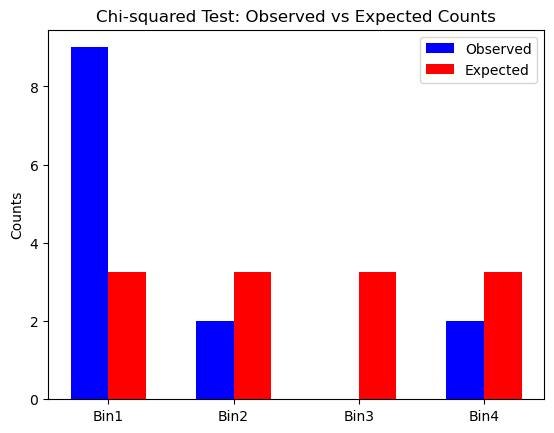

In [7]:
# all procedures average waiting is the average amount of
# waiting procedures per health authority summing all categories

bins = ['Bin1', 'Bin2', 'Bin3', 'Bin4']

fig, ax = plt.subplots()
width = 0.3  # Bar width

x = np.arange(len(bins))

ax.bar(x - width / 2, counts, width, label='Observed', color='blue')
ax.bar(x + width / 2, expected, width, label='Expected', color='red')

ax.set_ylabel('Counts')
ax.set_title('Chi-squared Test: Observed vs Expected Counts')
ax.set_xticks(x)
ax.set_xticklabels(bins)
ax.legend()

plt.show()
